In [1]:
import math
import itertools

import pandas as pd
from sqlalchemy.sql import select

from predict_aqi.load_data import (
    AirLocation, get_db_session, load_air_location_data, load_measurement_data,
    load_nearby_location_measurement_data
)

# Select some airlocation with bad aqi
session = get_db_session()
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_id = session.execute(s).scalar()
some_airlocation = load_air_location_data(some_airlocation_id)

print("{}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))

measurements = load_measurement_data(some_airlocation_id)

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


Mudanjiang, China


In [2]:
# Select classifier to use
from sklearn.neural_network import MLPRegressor
from predict_aqi.model import generate_AQI_inputs_and_outputs
from predict_aqi import config


indices_ahead_to_predict = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 2)
indices_behind_to_use = range(1, 16)
df, input_columns, output_columns = generate_AQI_inputs_and_outputs(
    measurements, indices_behind_to_use, indices_ahead_to_predict
)

In [3]:
# Define functions for generate_predictions method

from predict_aqi.transform_data import generate_time_inputs


def first_step_format_inputs_outputs(all_data):
    return all_data, input_columns, output_columns

 
def first_step_split_function(all_data, input_columns, output_columns):
    # Split by the first 90% of data. That means we're our testing set is extrapolation.
    row_count = all_data.count()[0]
    split_row = int(round(row_count * 0.90))
    # x_train, y_train, x_test, y_test
    return (all_data[input_columns][:split_row], 
            all_data[output_columns][:split_row],
            all_data[input_columns][split_row:],
            all_data[output_columns][split_row:])


def second_step_format_inputs_outputs(all_data):
    all_data, time_columns = generate_time_inputs(all_data)
    first_step_prediction_columns = ['{}_ahead_first_step_pred'.format(str(i)) 
                                     for i in indices_ahead_to_predict]
    second_input_columns = list(itertools.chain(time_columns, first_step_prediction_columns))
    # return the right columns
    return all_data, second_input_columns, output_columns

second_step_split_function = first_step_split_function

In [4]:
from predict_aqi.model import generate_predictions
from sklearn.metrics import mean_absolute_error
import copy


row_count = df.count()[0]
split_row = int(round(row_count * 0.90))
largest_input_columns = copy.deepcopy(input_columns)

errors = {}

for indices_behind_to_use_index in range(2, 17, 1):
    input_columns = largest_input_columns[:indices_behind_to_use_index]
    first_step_regressor = MLPRegressor()
    second_step_regressor = MLPRegressor()
    this_iteration_df = df.copy(deep=True)
    this_iteration_df = generate_predictions(
        this_iteration_df,
        first_step_format_inputs_outputs,
        first_step_split_function,
        second_step_format_inputs_outputs,
        second_step_split_function,
        first_step_regressor,
        second_step_regressor,
        indices_ahead_to_predict,
    )
    this_iteration_error_dict = {'first_step': {}, 'second_step': {}}
    for i in range(12, 50, 2):
        this_iteration_error_dict['first_step'][i] = mean_absolute_error(
            this_iteration_df['{}_ahead_AQI'.format(i)][:split_row], 
            this_iteration_df['{}_ahead_first_step_pred'.format(i)][:split_row]
        )
        this_iteration_error_dict['second_step'][i] = mean_absolute_error(
            this_iteration_df['{}_ahead_AQI'.format(i)][:split_row], 
            this_iteration_df['{}_ahead_second_step_pred'.format(i)][:split_row]
        )
    errors[indices_behind_to_use_index] = this_iteration_error_dict
    del this_iteration_df

Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.459
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.022
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.854
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.463
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.022
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.748
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.461
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.022
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.905
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.453
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.028
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.842
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.459
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.022
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.798
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.468
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.023
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.686
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.470
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.023
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.813
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.475
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.022
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.857
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.025
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.485
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.850
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.025
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.490
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.022
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.849
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.023
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.490
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.022
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.807
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.492
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.022
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.823
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.585
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.021
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.690
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.591
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.023
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.793
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.023
Step 1
Training MLPRegressor...


Done!
Training time (secs): 0.494
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.023
Step 2


Training MLPRegressor...


Done!
Training time (secs): 0.828
Predicting values using MLPRegressor...
Done!
Prediction time (secs): 0.024


In [5]:
distances = range(2, 17, 1)
first_step_errors = {
    i: [n * config.MAX_AQI for n in errors[i]['first_step'].values()]
    for i in distances
}

second_step_errors = {
    i: [n * config.MAX_AQI for n in errors[i]['second_step'].values()]
    for i in distances
}

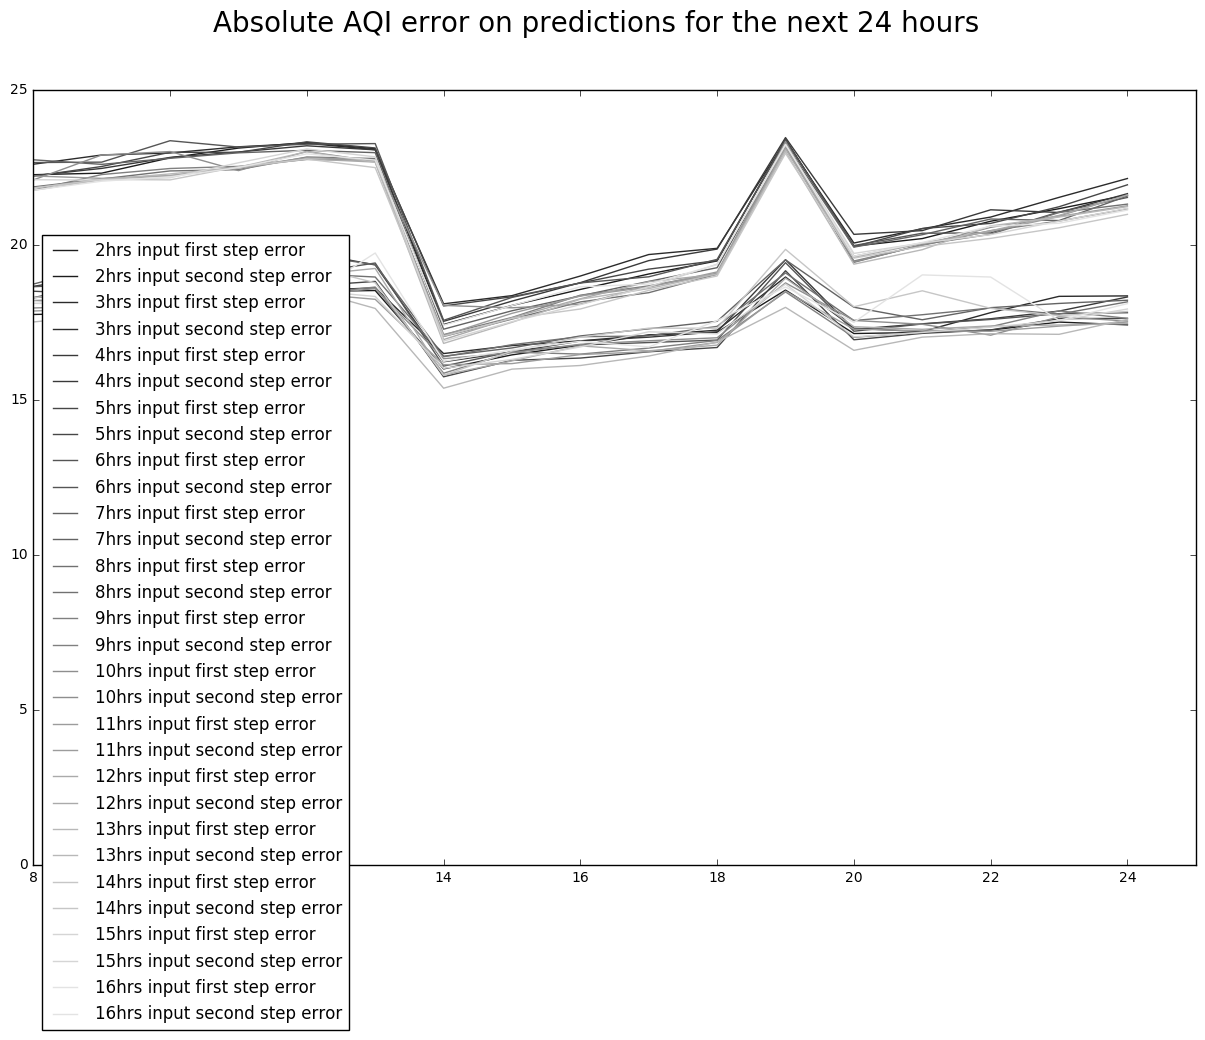

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.axis([8.0, 25.0, 0.0, 25.0])
for distance in sorted(first_step_errors.keys()):
    plt.plot(
        range(6, 25, 1), 
        first_step_errors[distance], 
        label="{}hrs input first step error".format(distance),
        color=str(distance / 18)
    )
    plt.plot(
        range(6, 25, 1), 
        second_step_errors[distance], 
        label="{}hrs input second step error".format(distance),
        color=str(distance / 18)
    )
plt.legend(loc=6, bbox_to_anchor=(0, 0.3))
plt.suptitle("Absolute AQI error on predictions for the next 24 hours", fontsize=20)

In [7]:
for distance in sorted(first_step_errors.keys()):
    error_values = second_step_errors[distance]
    dict_len = len(error_values)
    print("Distance into the past of inputs used: {}".format(distance))
    print("Sum of absolute AQI error in first 12 hours of prediction: {}".format(
        sum(error_values[:dict_len // 2])
    ))
    print("Sum of absolute AQI error in last 12 hours of prediction: {}".format(
        sum(error_values[dict_len // 2:])
    ))

Distance into the past of inputs used: 2
Sum of absolute AQI error in first 12 hours of prediction: 161.76335681402222
Sum of absolute AQI error in last 12 hours of prediction: 172.56968176582535
Distance into the past of inputs used: 3
Sum of absolute AQI error in first 12 hours of prediction: 165.20420790630658
Sum of absolute AQI error in last 12 hours of prediction: 176.01122378919655
Distance into the past of inputs used: 4
Sum of absolute AQI error in first 12 hours of prediction: 169.70327098998501
Sum of absolute AQI error in last 12 hours of prediction: 175.7541368323305
Distance into the past of inputs used: 5
Sum of absolute AQI error in first 12 hours of prediction: 164.79182837574163
Sum of absolute AQI error in last 12 hours of prediction: 171.66201802047524
Distance into the past of inputs used: 6
Sum of absolute AQI error in first 12 hours of prediction: 167.68679581400562
Sum of absolute AQI error in last 12 hours of prediction: 174.4245557606995
Distance into the past